In [1]:
! pip install ts2vg

In [2]:
import numpy as np
import os
import mne
import warnings
import networkx as nx
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:

from ts2vg import NaturalVG,HorizontalVG

NASA_dataset_root = '/Users/athenasaghi/Downloads/EEG'
files = os.listdir(NASA_dataset_root)
filtered_files = [file for file in files if 'BB' in file]
filtered_files,len(filtered_files)

(['2764BB',
  '2760BB',
  '2763BB',
  '2757BB',
  '2766BB',
  '2762BB',
  '2750BB',
  '2765BB',
  '2761BB'],
 9)

In [16]:
for fname in filtered_files:
    vhdr_file_path = os.path.join(NASA_dataset_root,f'{fname}/{fname}_D1.vhdr')
    raw = mne.io.read_raw_brainvision(vhdr_file_path, preload=True)
    signal, times = raw[:]
    vg = HorizontalVG(weighted='h_distance')
    vg.build(signal[0][:10])
    nxg = vg.as_networkx()
    break


Extracting parameters from /Users/athenasaghi/Downloads/EEG/2764BB/2764BB_D1.vhdr...
Setting channel info structure...
Reading 0 ... 996549  =      0.000 ...  3986.196 secs...


In [17]:

def calculate_metrics(adjacency_matrix):
    # Create a NetworkX graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(adjacency_matrix))
    
    # Number of nodes
    N = G.number_of_nodes()
    
    # Number of edges
    E = G.number_of_edges()
    
    # 1. Density
    D = (2 * E) / (N * (N - 1))
    
    # 2. Average Clustering Coefficient
    clustering_coeffs = nx.clustering(G)
    ACC = np.mean(list(clustering_coeffs.values()))
    
    # 3. Average Local Efficiency
    local_efficiencies = nx.local_efficiency(G)
    ALE = np.mean(local_efficiencies)
    
    # 4. Global Efficiency
    GE = nx.global_efficiency(G)
    
    return {
        "Density (D)": D,
        "Average Clustering Coefficient (ACC)": ACC,
        "Average Local Efficiency (ALE)": ALE,
        "Global Efficiency (GE)": GE
    }

metrics = calculate_metrics(vg.adjacency_matrix())
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Density (D): 0.2000
Average Clustering Coefficient (ACC): 0.0000
Average Local Efficiency (ALE): 0.0000
Global Efficiency (GE): 0.4287


In [13]:
ts, times = raw[:]
ts[0]

array([0.00027, 0.00027, 0.00028, ..., 0.01264, 0.01264, 0.01263])

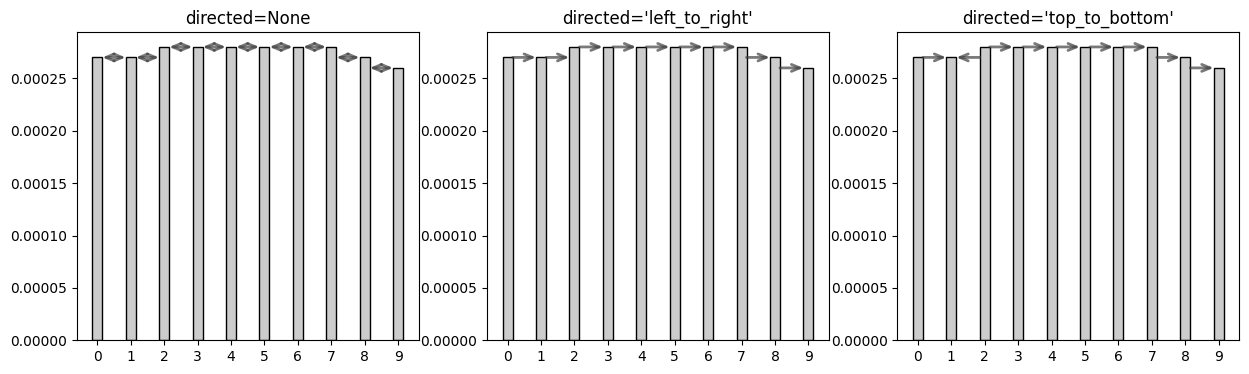

In [20]:
from plot_utils import plot_hvg

direction_options = [
    None,
    "left_to_right",
    "top_to_bottom",
]

fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

for d, ax in zip(direction_options, axs):
    ax.set_title(f"directed={repr(d)}")

    hvg = HorizontalVG(directed=d).build(signal[0][:10])
    plot_hvg(hvg, ax=ax)



Text(0, 0.5, 'P(k)')

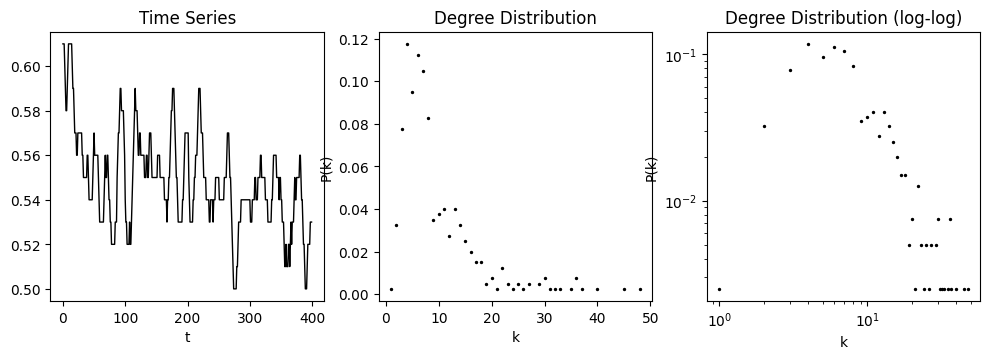

In [66]:

# 3. Get degree distribution
ks, ps = vg.degree_distribution

# 4. Make plots
fig, [ax0, ax1, ax2] = plt.subplots(ncols=3, figsize=(12, 3.5))

ax0.plot(ts, c="#000", linewidth=1)
ax0.set_title("Time Series")
ax0.set_xlabel("t")

ax1.scatter(ks, ps, s=2, c="#000", alpha=1)
ax1.set_title("Degree Distribution")
ax1.set_xlabel("k")
ax1.set_ylabel("P(k)")

ax2.scatter(ks, ps, s=2, c="#000", alpha=1)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_title("Degree Distribution (log-log)")
ax2.set_xlabel("k")
ax2.set_ylabel("P(k)")

In [67]:
ks,ps

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36,
        37, 40, 45, 48], dtype=uint32),
 array([0.0025, 0.0325, 0.0775, 0.1175, 0.095 , 0.1125, 0.105 , 0.0825,
        0.035 , 0.0375, 0.04  , 0.0275, 0.04  , 0.0325, 0.025 , 0.02  ,
        0.015 , 0.015 , 0.005 , 0.0075, 0.0025, 0.0125, 0.005 , 0.0025,
        0.005 , 0.0025, 0.005 , 0.005 , 0.0075, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0075, 0.0025, 0.0025, 0.0025, 0.0025]))

In [59]:
# ~~ plot_nvg
from matplotlib.patches import ArrowStyle, FancyArrowPatch


def plot_nvg(
    vg,
    ax,
    edge_color=(0.25, 0.25, 0.25, 0.7),
):
    bars = ax.bar(vg.xs, vg.ts, color="#ccc", edgecolor="#000", width=0.3)
    ax.set_xticks(vg.xs)

    for (n1, n2) in vg.edges:
        x1, y1 = vg.xs[n1], vg.ts[n1]
        x2, y2 = vg.xs[n2], vg.ts[n2]

        arrow = FancyArrowPatch(
            (x1, y1),
            (x2, y2),
            arrowstyle=ArrowStyle("->", head_length=6, head_width=2.5) if vg.is_directed else ArrowStyle("-"),
            shrinkA=0,
            shrinkB=0,
            color=edge_color,
            linewidth=2,
        )

        ax.add_patch(arrow)


# $$

# ~~ plot_hvg
from matplotlib.patches import ArrowStyle, FancyArrowPatch


def plot_hvg(
    vg,
    ax,
    edge_color=(0.25, 0.25, 0.25, 0.7),
    bar_width=0.3,
    prevent_overlap=False,
):
    occupied_heights = set()

    bars = ax.bar(vg.xs, vg.ts, color="#ccc", edgecolor="#000", width=bar_width)
    ax.set_xticks(vg.xs)

    for i, (n1, n2) in enumerate(vg.edges):
        y = min(vg.ts[n1], vg.ts[n2])

        if prevent_overlap:
            # very naive overlap prevention
            while round(y, 2) in occupied_heights:
                y -= 0.18

            occupied_heights.add(round(y, 2))

        if n1 < n2:
            x1, y1 = vg.xs[n1] + (bar_width / 2), y
            x2, y2 = vg.xs[n2] - (bar_width / 2), y
        else:
            x1, y1 = vg.xs[n1] - (bar_width / 2), y
            x2, y2 = vg.xs[n2] + (bar_width / 2), y

        arrow = FancyArrowPatch(
            (x1, y1),
            (x2, y2),
            arrowstyle=(
                ArrowStyle("->", head_length=6, head_width=2.5)
                if vg.is_directed
                else ArrowStyle("<->", head_length=6, head_width=2.5)
            ),
            shrinkA=0,
            shrinkB=0,
            color=edge_color,
            linewidth=2,
        )

        ax.add_patch(arrow)


# $$

# ~~ plot_weighted_nvg
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import ArrowStyle, FancyArrowPatch


def plot_weighted_nvg(
    vg,
    ax,
    cbar_ax,
    weights_cmap="coolwarm_r",
    weights_range=(-3.5, 3.5),
):
    bars = ax.bar(vg.xs, vg.ts, color="#ccc", edgecolor="#000", width=0.3)
    ax.set_xticks(vg.xs)

    color_mappable = ScalarMappable(norm=Normalize(*weights_range), cmap=weights_cmap)
    cbar_ax.get_figure().colorbar(color_mappable, cax=cbar_ax, orientation="vertical", aspect=30, pad=0.05)

    for (n1, n2, w) in vg.edges:
        x1, y1 = vg.xs[n1], vg.ts[n1]
        x2, y2 = vg.xs[n2], vg.ts[n2]

        arrow = FancyArrowPatch(
            (x1, y1),
            (x2, y2),
            arrowstyle=ArrowStyle("-"),
            shrinkA=0,
            shrinkB=0,
            color=color_mappable.to_rgba(w, alpha=1),
            linewidth=2,
        )

        ax.add_patch(arrow)


# $$

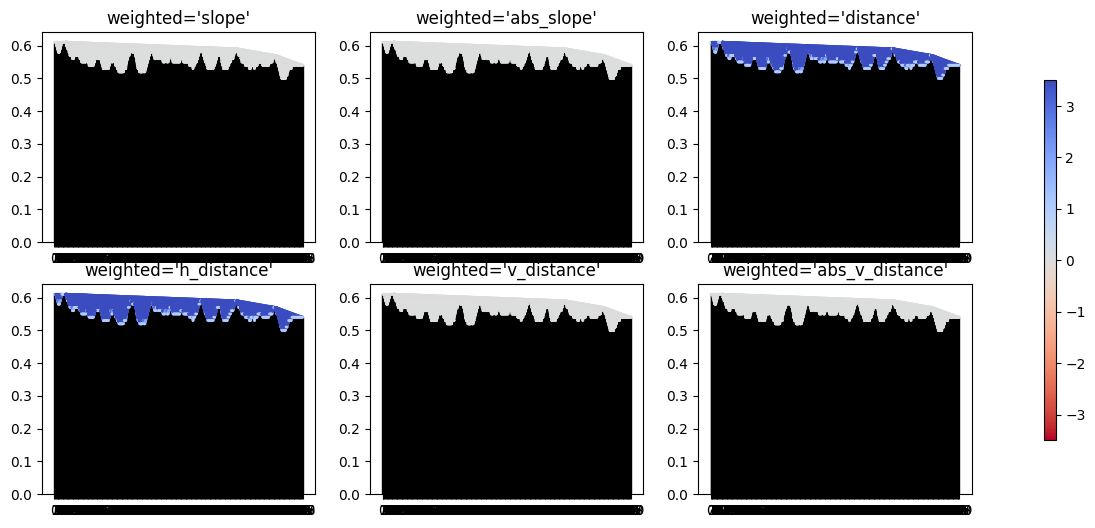

In [61]:
weight_options = [
    "slope",
    "abs_slope",
    "distance",
    "h_distance",
    "v_distance",
    "abs_v_distance",
]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
cbar_ax = fig.add_axes([0.96, 0.2, 0.01, 0.6])

for w, ax in zip(weight_options, axs.flat):
    ax.set_title(f"weighted='{w}'")

    nvg = NaturalVG(weighted=w).build(ts)
    plot_weighted_nvg(nvg, ax=ax, cbar_ax=cbar_ax)

In [ ]:
nx.draw_networkx(nxg, ax=ax1, pos=vg.node_positions(), **graph_plot_options)
ax1.tick_params(bottom=True, labelbottom=True)
ax1.plot(ts)
ax1.set_title("Visibility Graph")

nx.draw_networkx(nxg, ax=ax2, pos=nx.kamada_kawai_layout(nxg), **graph_plot_options)
ax2.set_title("Visibility Graph")